# Convolutional Neural Networks

## Introduction

Today we discuss convolutional neural networks (CNNs). But first we are going to give a quick introduction to PyTorch.

PyTorch is a python library for building machine learning models.

## Introduction

PyTorch has two main features:

1. Tensors
2. Autograd

## Introduction

Tensors in PyTorch are basically the same thing as numpy ndarrays except that you can do operations on PyTorch tensors with a GPU.

By convention, the first dimension of a PyTorch tensor is usually the mini-batch dimension.

For example you should interpret a tensor of shape `(2, 10)` as an array that contains two vectors with 10 components each and a tensor of shape `(3, 5, 5)` as an array that contains three 5 by 5 matrices.

## Introduction

Autograd does backpropagation.
That is it computes derivatives of composite functions.
You can read more about autograd [here](https://docs.pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html).

Here is how to compute derivatives with Pytorch:

In [1]:
import torch

x = torch.tensor([1., 2., 3.], requires_grad=True)
torch.sin(x**2).sum().backward()
print(x.grad)
print(2*x*torch.cos(x**2))

tensor([ 1.0806, -2.6146, -5.4668])
tensor([ 1.0806, -2.6146, -5.4668], grad_fn=<MulBackward0>)


## Introduction

To call `.backwards()` the function must output a single number.
After calling it the partial derivatives are deposited into the `grad` property of the input tensors.


## Loading data

We also need to learn how to load data in PyTorch.

PyTorch has two abstractions: a `Dataset` class and a `DataLoader` class. The `Dataset` class represents your data, while `DataLoader` wraps `Dataset` and allows you to iterate over it.

## Loading data

In this chapter we will use the CIFAR10 dataset:

![](../images/cifar10.png){fig-align="center"}

This dataset ships with Torchvision which is a sub library of PyTorch that adds utils for handling pictures.

Here is how to load the dataset:

## Loading data

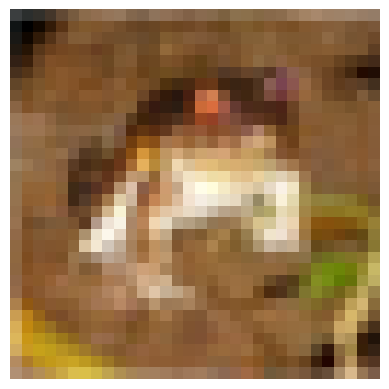

In [2]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt
import numpy as np

def show(img):
  """Function for displaying image"""
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.axis('off')

train_data = datasets.CIFAR10(
  root="data",
  train=True,
  download=True,
  transform=ToTensor(),
  # One hot encodes the target
  target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

test_data = datasets.CIFAR10(
  root="data",
  train=False,
  download=True,
  transform=ToTensor(),
  # One hot encodes the target
  target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

img, target = train_data[0]
show(img)

## Loading data

In [3]:
print(target)
channels, height, width = img.shape
print(f"Dimensions of image: C:{channels}, H:{height}, W:{width}")

tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
Dimensions of image: C:3, H:32, W:32


## Building the model

To build a model in PyTorch we need to define a class that inherits from the PyTorch's `Module` class.

In the constructor we define the architecture of our model. We also need to implement the `forward` method where we define the forward pass of our model. We do not need to define the backward pass for backpropagation, PyTorch figures it out automatically.

Also, for classification models, do not apply softmax to the output layer as the PyTorch's cross-entropy loss implementation already does that. We discussed why this is done in the last chapter.

## Building the model

In [4]:
#| output-location: slide
from torch import nn

class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten() # Flattens out the image into a vector
    self.linear_relu_stack = nn.Sequential(
      nn.Linear(3*32*32, 512),
      nn.ReLU(),
      nn.Linear(512, 512),
      nn.ReLU(),
      nn.Linear(512, 10),
    )

  def forward(self, x):
    x = self.flatten(x)
    return self.linear_relu_stack(x)

print(NeuralNetwork())

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## Dataloaders

Let's define our dataloaders.

In [5]:
batch_size = 128

train_dataloader = DataLoader(
  train_data,
  batch_size=batch_size,
  shuffle=True # Whether to shuffle the data every loop, useful for SGD
)

test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

## Training the model

Let's define functions to train the model for 1 epoch.

In [6]:
from tqdm import tqdm # This is a library that implements loading bars
import sys

def train_epoch(dataloader, model, loss_fn, optimizer):
  model.train() # Set model to training mode

  total_loss = 0
  total_batches = 0

  with tqdm(dataloader, unit="batch", file=sys.stdout) as ep_tqdm:
    ep_tqdm.set_description("Train")
    for X, y in ep_tqdm:
      X, y = X.to(device), y.to(device)

      # Forward pass
      pred = model(X)
      loss = loss_fn(pred, y)
        
      # Backward pass
      loss.backward()
      optimizer.step()

      # Reset the computed gradients back to zero
      optimizer.zero_grad()

      # Output stats
      total_loss += loss
      total_batches += 1
      ep_tqdm.set_postfix(average_batch_loss=(total_loss/total_batches).item())

def eval_epoch(dataloader, model, loss_fn):
  model.eval() # Set model to inference mode
  
  total_loss = 0
  total_batches = 0
  total_samples = 0
  total_correct = 0

  with torch.no_grad(): # Do not compute gradients
    with tqdm(dataloader, unit="batch", file=sys.stdout) as ep_tqdm:
      ep_tqdm.set_description("Val")
      for X, y in ep_tqdm:
        X, y = X.to(device), y.to(device)
        pred = model(X)

        total_loss += loss_fn(pred, y)
        total_correct += (pred.argmax(dim=1) == y.argmax(dim=1)).type(torch.float).sum()
        total_samples += len(X)
        total_batches += 1

        ep_tqdm.set_postfix(average_batch_loss=(total_loss/total_batches).item(), accuracy=(total_correct/total_samples).item())

## Training the model

Now all that there is left to do is to define the loss function and organize the training loop.

In [7]:
#| output-location: slide
# Use GPU if available
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

model = NeuralNetwork().to(device) # This tells pytorch which device to use when training and inferencing

# Hyperparameters
learning_rate = 0.001
epochs = 3

loss_fn = nn.CrossEntropyLoss().to(device) # Initialize the loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Initialize the optimizer

# Organize the training loop
for t in range(epochs):
  print(f"Epoch {t+1}\n")
  train_epoch(train_dataloader, model, loss_fn, optimizer)
  eval_epoch(test_dataloader, model, loss_fn)
  print("-------------------------------")

print("Done!")

Using cuda device
Epoch 1

Val: 100%|██████████| 79/79 [00:00<00:00, 191.20batch/s, accuracy=0.394, average_batch_loss=1.7] 
-------------------------------
Epoch 2

Val: 100%|██████████| 79/79 [00:00<00:00, 185.91batch/s, accuracy=0.431, average_batch_loss=1.61]
-------------------------------
Epoch 3

Val: 100%|██████████| 79/79 [00:00<00:00, 184.86batch/s, accuracy=0.462, average_batch_loss=1.52]
-------------------------------
Done!


## Training the model

We can also save the trained model to disk and load it as follows.

In [8]:
torch.save(model, 'model.pth')
model1 = torch.load('model.pth', weights_only=False)
print(model1)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## Training the model

You can also save only the weights of the model and not the model structure as follows.

In [9]:
torch.save(model.state_dict(), 'model_weights.pth')
model1 = NeuralNetwork()
model1.load_state_dict(torch.load('model_weights.pth', weights_only=True))

<All keys matched successfully>

## Convolution

Convolutional Neural Networks (CNNs) are networks that have convolutional layers. Convolutional layers perform the convolution operation.

Convolution operation is pretty simple. You take your input matrix and then you take a smaller matrix called the filter. Then you slide your filter matrix along the input matrix and at each step you multiply the matrices componentwise and sum up. This way you get a matrix as output.

## Convolution

Its easier to understand the operation by looking at a picture:

![](../images/convolution.png){fig-align="center"}

## Convolution

We've defined the 2d convolution operation. You can define 1d or $n$d convolution operations similarly.

Convolutions let the model group up inputs that are spatially close to each other and then learn patterns.

Also convolutions can learn patterns irrespective of where they appear in the input. This can be quite difficult for a model with only fully connected layers.

These two properties make convolutions work very well on images, as you can imagine.

## Convolution

Let's see how to apply the convolution operation in PyTorch.

Input image:


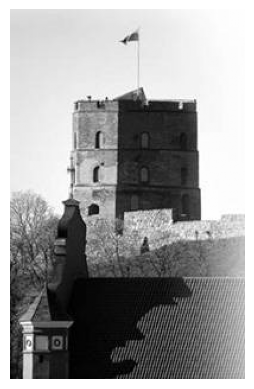

In [10]:
#| output-location: slide

import torch
from torch import nn
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def show(img):
  """Function for displaying image"""
  plt.imshow(img.squeeze(), cmap='gray')
  plt.axis('off')

img = Image.open('../images/castle.jpg')
img.load()
img = torch.from_numpy(np.asarray(img, dtype="int32") / 255)

print("Input image:")
show(img)

## Convolution

Let's apply the edge detection filter.

Edge detection applied:


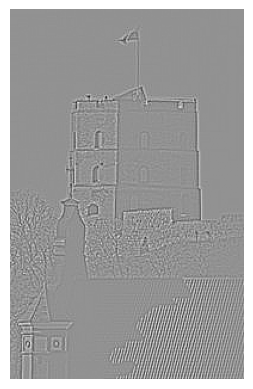

In [11]:
#| output-location: slide
conv = nn.Conv2d(
  in_channels=1, # How many channel our input has, we have a monochrome image so its 1 in our case
  out_channels=1, # How many filters to use
  kernel_size=(3, 3), # Filter matrix size
  bias=False
)
filter_matrix = torch.tensor(
  [[-1, -1, -1],
  [-1,  8, -1],
  [-1, -1, -1]], dtype=torch.float64
).unsqueeze(0).unsqueeze(0) # The unsqueezes are there to have the correct dimensions
conv.weight = nn.Parameter(filter_matrix) # Manually set the filter
print("Edge detection applied:")
show(conv(img.unsqueeze(0)).detach().numpy()[0])

## Convolution

The `nn.Conv2d` in pytorch has parameter `groups` that determines how the layer works with multiple input channels.

Note that the output is always going to have the number of channels that you specified in the `out_channels` parameter. Also the number of filters in the layer is also always going to be equal to `out_channels`, however how the filters are applied on input channels depends on  the `groups` parameter.

## Convolution

If `groups=1` (this is the default) every filter is going to be applied to every input channel and the results summed up to get an output channel:

$$
    \text{out_channel}_i = \text{bias}_i + \sum_{j=1}^{\text{in_channels}} \text{filter}_i \star \text{in_channel}_j
$$

## Convolution

If `groups=2` then half of the filters is applied to half of the input channels (same thing as having two Conv2d layers side by side operating on half of the input channels).

If `groups=in_channels` then every input channel has its own filters.

## Convolutional Neural Networks

Let's build a CNN.

In [12]:
#| output-location: slide
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.convolution = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=12, kernel_size=(3, 3)),
      nn.MaxPool2d(kernel_size=(2, 2)),
      nn.BatchNorm2d(num_features=12), # num_features - how many channels the input has
      nn.Conv2d(in_channels=12, out_channels=24, kernel_size=(3, 3)),
      nn.MaxPool2d(kernel_size=(2, 2))
    )
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
      nn.Linear(864, 1028),
      nn.ReLU(),
      nn.Linear(1028, 1028),
      nn.ReLU(),
      nn.Linear(1028, 10),
    )

  def forward(self, x):
    x = self.convolution(x)
    x = self.flatten(x)
    return self.linear_relu_stack(x)

print(CNN())

CNN(
  (convolution): Sequential(
    (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=864, out_features=1028, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1028, out_features=1028, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1028, out_features=10, bias=True)
  )
)


## Convolutional Neural Networks

We used two layers we have not discussed yet:

1. Max pooling
2. Batch normalization

## Convolutional Neural Networks

Max pooling constructs a lower resolution image from a given one by keeping only the max value from a region. These layers are commonly used with convolution layers to make the image slightly more translation invariant.

This image summarizes max pooling:

![](../images/maxpooling.png){fig-align="center"}

## Convolutional Neural Networks

Batch normalization layer works as follow.

During training suppose you have a batch of $m$ input vectors of dimension $d$ - $x_i = (x_{i1}, \dots, x_{id})$.
Then you compute the batch mean and variance:
$$
    \mu_B = \frac{1}{m}\sum_{i=1}^m x_i, \sigma_B^2 = \frac{1}{m}\sum_{i=1}^m (x_i-\mu_B)^2,
$$
the operations here and elsewhere in this section are componentwise.

## Convolutional Neural Networks

Then you normalize:
$$
    \hat{x_i} = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \varepsilon}}
$$
Then to compute the output you use two extra learnable parameters - $\gamma$ and $\beta$ which are $d$ dimensional vectors:
$$
    y_i = \gamma \hat{x_i} + \beta.
$$

## Convolutional Neural Networks

During inference instead of using batch mean and variance you use the mean and variance of your whole training set to produce deterministic outputs.

It is funny, but it is actually unknown why batch normalization works (there are several theories but experts don't agree which one is correct). But it is known empirically that it improves model performance.

## Convolutional Neural Networks

There is another popular choice for normalization - layer normalization.

This time you normalize each feature using the mean and variance of the features of a single sample. This is as opposed to using the mean and variance of a single feature across the batch.

## Convolutional Neural Networks

Suppose you have a batch of $m$ input vectors of dimension $d$ - $x_i = (x_{i1}, \dots, x_{id})$.
So this time what you do is 
$$
    \mu_i = \frac{1}{d}\sum_{j=1}^d x_{ij}, \sigma_i^2 = \frac{1}{d}\sum_{j=1}^d (x_{ij}-\mu_i)^2,
$$
Then you normalize:
$$
    \hat{x_{ij}} = \frac{x_{ij} - \mu_i}{\sqrt{\sigma_i^2 + \varepsilon}}
$$

## Convolutional Neural Networks

Then to compute the output you use two extra learnable parameters - $\gamma$ and $\beta$ which are $d$ dimensional vectors:
$$
    y_i = \gamma \hat{x_i} + \beta.
$$
This layer works the same during inference as it does during training.

## Convolutional Neural Networks

Some layers (such as batch normalization) act slightly differently depending on whether you are training the model or using it to make predictions.

You can switch between the two modes in Pytorch by calling `model.train()` and `model.eval()`.

## Convolutional Neural Networks

Let's train our CNN. We can copy paste the previous code.


In [13]:
#| output-location: slide

# Use GPU if available
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

model = CNN().to(device) # This tells pytorch which device to use when training and inferencing

# Hyperparameters
learning_rate = 0.001
epochs = 3

loss_fn = nn.CrossEntropyLoss().to(device) # Initialize the loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Initialize the optimizer

# Organize the training loop
for t in range(epochs):
  print(f"Epoch {t+1}\n")
  train_epoch(train_dataloader, model, loss_fn, optimizer)
  eval_epoch(test_dataloader, model, loss_fn)
  print("-------------------------------")

print("Done!")

Using cuda device
Epoch 1

Val: 100%|██████████| 79/79 [00:00<00:00, 186.18batch/s, accuracy=0.578, average_batch_loss=1.2] 
-------------------------------
Epoch 2

Val: 100%|██████████| 79/79 [00:00<00:00, 194.69batch/s, accuracy=0.659, average_batch_loss=0.995]
-------------------------------
Epoch 3

Val: 100%|██████████| 79/79 [00:00<00:00, 188.09batch/s, accuracy=0.648, average_batch_loss=1.04]
-------------------------------
Done!


## Fine tuning

One nice thing about neural networks is that they are quite reusable. You can take a network that was pre trained on some dataset, change its output layers to fit your problem and then run a few epochs worth of training on your dataset. This process is called **fine tuning**.

Fine tuning pre trained networks reduces training costs as you will typically need less training time to get good results when compared to how long it would take you on a "fresh" model.

## Fine tuning

Let's see how to do fine tuning in PyTorch.

We will use ResNet. ResNet is a CNN model trained on [ImageNet](https://www.image-net.org/). The innovation of ResNet are residual connections (res stands for "residual"). They look like this:

![](../images/residuallayer.png){fig-align="center"}

## Fine tuning

That is in a residual connection we sum up the output of downstream layers with the output of the current layer.

This is again done to help with training. It helps with the vanishing / exploding gradient problem.

Actually, you can show theoretically that batch normalization causes exploding gradients for fresh models with randomly initialized weights. Residual connections fix this issue.

## Fine tuning

Torchvision ships with some pre trained models for image processing tasks, ResNet included.

We are going to use ResNet50 which is the medium size version (~25.6 million parameters, ~100MB). You can see all available versions [here](https://pytorch.org/vision/main/models/resnet.html).

In [14]:
#| output-location: slide
from torchvision import models

resnet = models.resnet50(weights="ResNet50_Weights.DEFAULT")

# Change output dim
resnet.fc = nn.Linear(in_features=resnet.fc.in_features, out_features=10)

resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Fine tuning

We are also going to freeze the weights of the first few layers and only update the weights of the last layers of the model.

In [15]:
# Freeze some layers
for name, child in resnet.named_children():
    if name not in  ["fc", "avgpool", "layer3", "layer4"]:
        for param in child.parameters():
            param.requires_grad = False

resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Fine tuning

We can again reuse the code for training.

In [16]:
#| output-location: slide
# Use GPU if available
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

model = resnet.to(device) # This tells pytorch which device to use when training and inferencing

# Hyperparameters
learning_rate = 0.001
epochs = 1

loss_fn = nn.CrossEntropyLoss().to(device) # Initialize the loss function
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate) # Initialize the optimizer

# Organize the training loop
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train_epoch(train_dataloader, model, loss_fn, optimizer)
  eval_epoch(test_dataloader, model, loss_fn)

print("Done!")

Using cuda device
Epoch 1
-------------------------------
Val: 100%|██████████| 79/79 [00:00<00:00, 87.09batch/s, accuracy=0.814, average_batch_loss=0.554]
Done!


## What to read and watch

- [PyTorch tutorial from the docs](https://docs.pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
- [More on CNNs](https://www.youtube.com/watch?v=KuXjwB4LzSA)


## Practice task

Try to improve the CNN model we created to get a better score on CIFAR10. Try to figure out how to implement residual connections in PyTorch.

Also training times will be slow, unless you use a GPU. You can use a GPU for free in Google Colab in `Runtime -> Change runtime type`.